(unsupervised:autoencoders)=
# Autoencoders

An autoencoder is a special ANN mainly used for dimensionality reduction and anomaly detection. In principle, autoencoders can be used for generating new samples similar to training samples (generative model), but there exist much better generative models nowadays. We introduce autoencoders here, because they are a relatively simple ancestor of variational autoencoders, one of two very prominent generative machine learning techniques (the other prominent technique are generative adversarial networks).

Related projects:
* [](projects:mnist)
  * [](projects:mnist:autoencoder)

## ANN Structure

Like PCA, autoencoders aim at reducing feature space dimension without loosing relevant information. PCA follows a clear mathematical reasoning to reduce feature space dimension. In particular, for PCA the transform between original and reduced feature space is linear (multiplication by a matrix).
Autoencoders use ANNs for transforming features and also for the inverse transform. Thus, transformation may be highly nonlinear and, thus, much more flexible.

Encoder ANN and decoder ANN are trained simultaneously by joining them to form one large ANN. The input neurons of the decoder are connected to the output neurons of the encoder. Training data consists of (unlabeled) samples which are used both as inputs and as outputs of the ANN. So the ANN learns to reproduce its inputs!

The output of the encoder sometimes is denoted as *code*. If the number of encoder output neurons (dimension of reduced feature space or code space) is smaller than the original feature space dimension, then the ANN is forced to drop information not relevant for reproducing inputs.

```{figure} autoencoder.svg
---
alt: structure of autoencoder
---
Autoencoders are ANNs with as many outputs as inputs.
```

There is nothing special about training an autoencoder. Usually mean squared error is used as loss. Regularization may be used to enforce certain special properties of the codes. An example are sparse codes (resulting from $\ell^1$-penalty), which may be used together with high dimensional code spaces to identify most relevant original features.

## Implementing an Autoencoder

Scikit-Learn does not offer autoencoders (at the moment), so we have to use Keras and create an ANN with special autoencoder structure manually.

We first create a simple toy data set for demonstration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

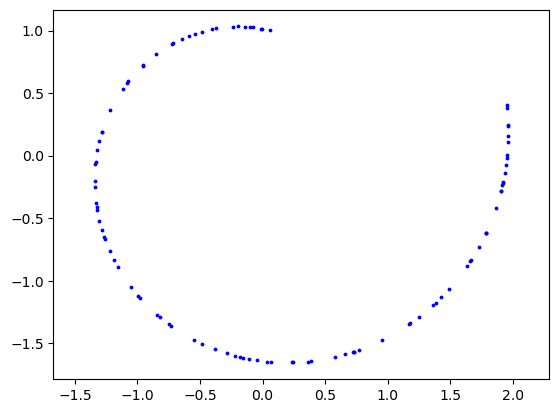

In [2]:
n = 100

t = rng.uniform(0, 1, n)
X = np.empty((n, 2))
X[:, 0] = (t + 1) * np.cos(5 * t + 1.5)
X[:, 1] = (t + 1) * np.sin(5 * t + 1.5)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c='b', s=3)
ax.axis('equal')
plt.show()

Original data space has two dimensions here. Human eye immediately sees that the data set lives on a one dimensional manifold. Thus, we could unwind the curve to map the data set into a one dimensional space without loss of information. So code space should have one dimension and the encoder ANN has to learn the unwinding operation. We give it a try with two small layers. Using only one layer would yield a more or less linear transform, which obviously cannot unwind the curve.

In [3]:
# disable GPU if TensorFlow with GPU causes problems
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow.keras as keras

2024-03-07 08:07:50.236721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
encoder = keras.Sequential(name='encoder')
encoder.add(keras.Input(shape=(2,)))
encoder.add(keras.layers.Dense(10, activation='relu', name='enc1'))
encoder.add(keras.layers.Dense(10, activation='relu', name='enc2'))
encoder.add(keras.layers.Dense(1, activation='linear', name='code'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc1 (Dense)                (None, 10)                30        
                                                                 
 enc2 (Dense)                (None, 10)                110       
                                                                 
 code (Dense)                (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


2024-03-07 08:07:52.104978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-07 08:07:52.105057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: WHZ-46349
2024-03-07 08:07:52.105077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: WHZ-46349
2024-03-07 08:07:52.105370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.147.5
2024-03-07 08:07:52.105437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.147.5
2024-03-07 08:07:52.105454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.147.5
2024-03-07 08:07:52.106016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with on

The decoder ANN looks the same because it as to learn the inverse of the encoder. So complexity of the mappings to learn by encoder and decoder is comparable.

In [5]:
decoder = keras.Sequential(name='decoder')
decoder.add(keras.Input(shape=(1,)))
decoder.add(keras.layers.Dense(10, activation='relu', name='dec1'))
decoder.add(keras.layers.Dense(10, activation='relu', name='dec2'))
decoder.add(keras.layers.Dense(2, activation='linear', name='reconstruction'))

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec1 (Dense)                (None, 10)                20        
                                                                 
 dec2 (Dense)                (None, 10)                110       
                                                                 
 reconstruction (Dense)      (None, 2)                 22        
                                                                 
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


Now we join encoder and decoder. Keras models can be used as layers of a new model. So we only have to create a sequential model with encoder and decoder as layers. Important: all three models use the same underlying computation graph.

In [6]:
autoencoder = keras.Sequential(name='autoencoder')
autoencoder.add(keras.Input(shape=(2,)))
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 1)                 151       
                                                                 
 decoder (Sequential)        (None, 2)                 152       
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


We see that the number of weights equals the sum of the weights of encoder and decoder. The autoencoder model shares weights with encoder and decoder models. If we train the autoencoder the weights of encoder and decoder get modified, too (because there is only one computation graph).

In [7]:
autoencoder.compile(loss='mean_squared_error')

loss = []

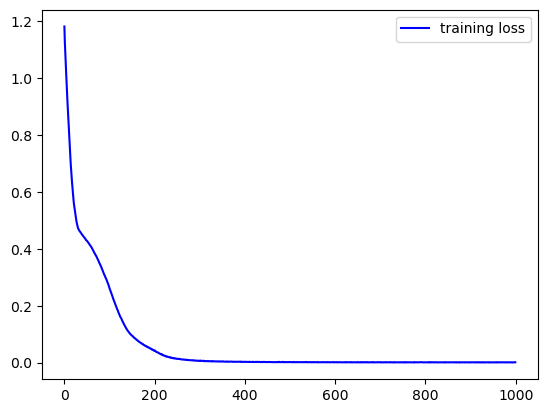

In [8]:
history = autoencoder.fit(X, X, epochs=1000, verbose=0)

loss.extend(history.history['loss'])

fig, ax = plt.subplots()
ax.plot(loss, '-b', label='training loss')
ax.legend()
plt.show()

To see whether training has been successful we may calculate root mean squared error and plot original and reconstructed data.

4/4 [==============================] - 0s 2ms/step
RMSE: 0.038026978404184425


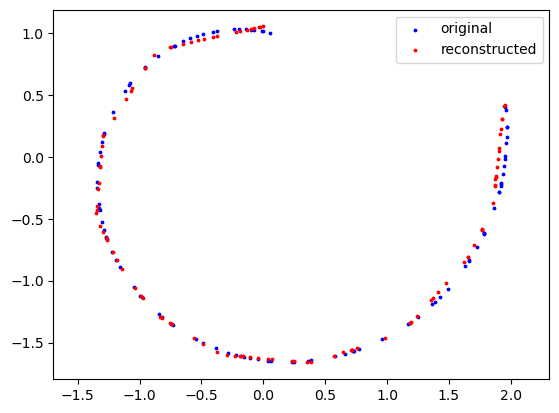

In [9]:
X_pred = autoencoder.predict(X)

print('RMSE:', np.sqrt(((X - X_pred) ** 2).sum() / n))

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c='b', s=3, label='original')
ax.scatter(X_pred[:, 0], X_pred[:, 1], c='r', s=3, label='reconstructed')
ax.axis('equal')
ax.legend()
plt.show()

Codes live in one dimension. To visualize the mapping of original data to codes we embed the one dimensional code space into the original data space and connect each sample with its code by a line.

4/4 [==============================] - 0s 2ms/step


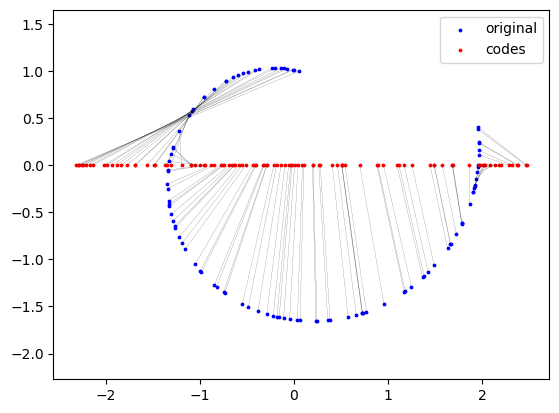

In [10]:
C = encoder.predict(X)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c='b', s=3, label='original')
ax.scatter(C, np.zeros_like(C), c='r', s=3, label='codes')
for l in range(0, n):
    ax.plot([X[l, 0], C[l, 0]], [X[l, 1], 0], 'k', linewidth=0.1)
ax.axis('equal')
ax.legend()
plt.show()

From the visualization we see that the autoencoder preserves order. This is not (!) a general property of autoencoders, but here it works.

## Comparison to PCA

For comparison we use PCA to reduce feature space dimesion.

In [11]:
import sklearn.decomposition as decomposition

In [12]:
pca = decomposition.PCA(1)
C_pca = pca.fit_transform(X)    # encoder
X_pca = pca.inverse_transform(C_pca)    # decoder

RMSE: 0.9049436506773132


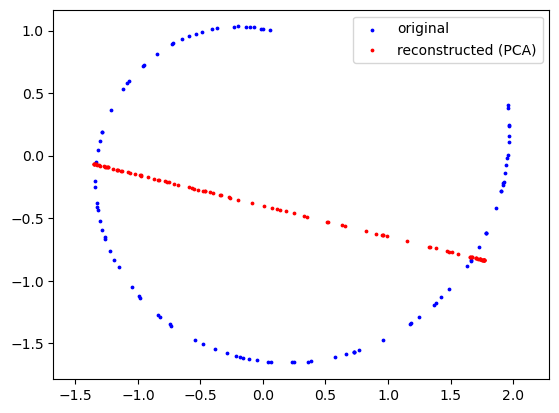

In [13]:
print('RMSE:', np.sqrt(((X - X_pca) ** 2).sum() / n))

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c='b', s=3, label='original')
ax.scatter(X_pca[:, 0], X_pca[:, 1], c='r', s=3, label='reconstructed (PCA)')
ax.axis('equal')
ax.legend()
plt.show()

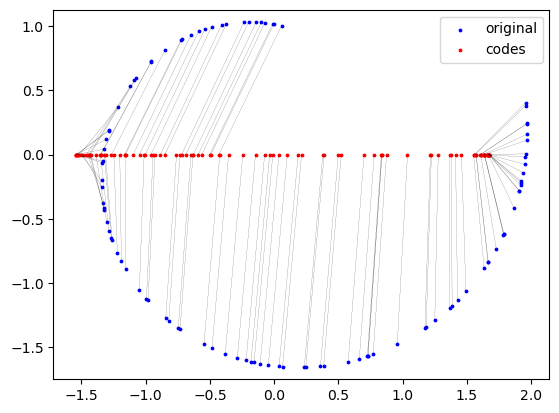

In [14]:
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c='b', s=3, label='original')
ax.scatter(C_pca, np.zeros_like(C_pca), c='r', s=3, label='codes')
for l in range(0, n):
    ax.plot([X[l, 0], C_pca[l, 0]], [X[l, 1], 0], 'k', linewidth=0.1)
ax.axis('equal')
ax.legend()
plt.show()

PCA maps distant points to similar codes because PCA maps original data to codes by orthogonal projection.

## Generating New Samples

Autoencoders can be used as generative models. If we feed some input (code) into the decoder, it will yield some output. At least if the input is in the range of codes generated from training data output should be close to original data, that is, similar to training samples.

1/1 [==============================] - 0s 43ms/step


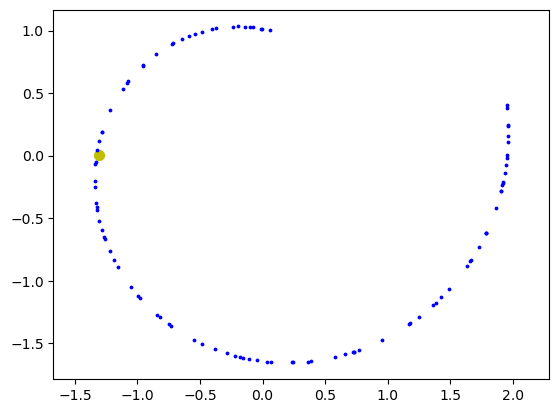

In [15]:
C_new = np.array([[-1]])
#C_new = np.linspace(-10, 10, 100).reshape(-1, 1)

X_new = decoder.predict(C_new)

fig, ax = plt.subplots()
ax.scatter(X_new[:, 0], X_new[:, 1], c='y', s=50)
ax.scatter(X[:, 0], X[:, 1], c='b', s=3)
ax.axis('equal')
plt.show()

## Anomaly Detection

Autoencoders typically yield good reconstructions only on data similar to training data. If we feed an autoencoder with samples very different from training data reconstructions won't look like inputs. This behavior can be used for anomaly detection. If an autoencoder is trained on 'positive' data only (legitimate credit card transactions for instance) it is likely to yield bad reconstructions on 'negative' samples (fraudulent credit card transactions).

1/1 [==============================] - 0s 63ms/step
RMSE: 2.8292557635876245


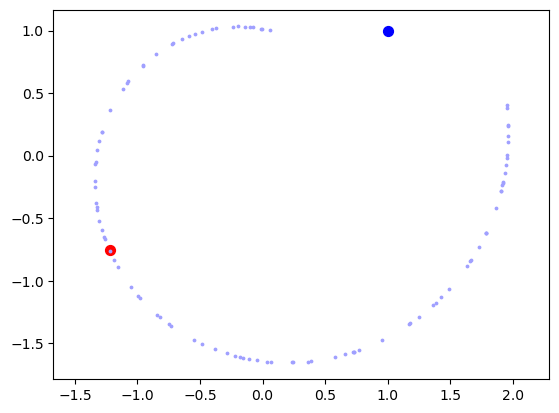

In [16]:
X_bad = np.array([[1, 1]])
#X_bad = np.array([[-1, -1]])

X_bad_pred = autoencoder.predict(X_bad)

print('RMSE:', np.sqrt(((X_bad - X_bad_pred) ** 2).sum() / len(X_bad)))

fig, ax = plt.subplots()
ax.scatter(X_bad[:, 0], X_bad[:, 1], c='b', s=50)
ax.scatter(X_bad_pred[:, 0], X_bad_pred[:, 1], c='r', s=50)
ax.scatter(X[:, 0], X[:, 1], c='#a0a0ff', s=3)
ax.axis('equal')
plt.show()

Calculating RMSE between original and reconstructed samples for a grid of samples we get a visual impression of the autoencoder mapping.

1250/1250 [==============================] - 2s 1ms/step


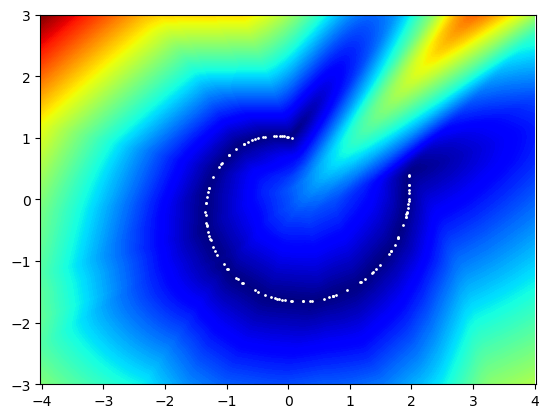

In [17]:
n_grid = 200

u, v = np.meshgrid(np.linspace(-4, 4, n_grid), np.linspace(-3, 3, n_grid))
X_grid = np.concatenate((u.reshape(-1, 1), v.reshape(-1, 1)), axis=1)

X_grid_pred = autoencoder.predict(X_grid)

errors = np.sqrt(((X_grid - X_grid_pred) ** 2).sum(axis=1) / len(X_grid))

fig, ax = plt.subplots()
ax.contourf(u, v, errors.reshape(n_grid, n_grid), cmap='jet', levels=200)
ax.scatter(X[:, 0], X[:, 1], c='w', s=1)
ax.axis('equal')
plt.show()

## Convolutional Autoencoders

For image processing task CNNs (convolutional ANNs) are known to perform much better than fully connected CNNs. Using a CNN as encoder is straight forward, but how to 'invert' a CNN for decoding? The decoder has to upsample the code until the original image size is reached. For this upsampling process we have to options:
* simple upsampling (e.g. duplicating each pixel),
* transposed convolution, also known as backward convolution.

A transposed convolution layer has inverse structure of a convolution layer (inputs and outputs switched). Like a usual convolutional layer, it is defined by a stack of filters (shared weights) and a stride value (step size for moving the filter to the next position). Note that a transposed convolution layer only inverts the structure (connections between neurons), not the calculation. So chaining convolution and transposed convolution is not the identity, but only the chain's input shape equals its output shape.

```{figure} transposed-conv.svg
---
alt: convolution versus transposed convolution
---
Transposed convolutions do NOT invert convolutions but corresponding shapes only.
```

From the computation scheme we see that transposed convolution can be regarded as usual convolution with zero padded inputs (add zeros on left and right side).

While stride is applied to inputs for usual convolution, for transposed convolution stride is applied to the outputs.

```{figure} strided-conv.svg
---
alt: strided usual and transposed convolution
---
Striding for transposed convolutions is realized such that resulting that input and output shapes match ouput and input shapes of corresponding usual convolution.
```

A decoder symmetric to a CNN encoder can be constructed by inverting the encoder's layer stack and replacing pooling by upsampling and convolutions by transposed convolutions. Corresponding Keras layers are [`UpSampling2D`](https://keras.io/api/layers/reshaping_layers/up_sampling2d) and [`Conv2DTranspose`](https://keras.io/api/layers/convolution_layers/convolution2d_transpose). 1d and 2d variants exist as well, but `Conv1DTranspose` not before TensorFlow 2.3.